In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
import torch
from matplotlib import pylab as P
import matplotlib.pyplot as plt
import os
from PIL import Image
from vin_big_dataset import Vin_big_dataset
from transform_vin_big import vin_big_transform
from model_global import global_model
from model_local import local_model
import matplotlib.patches as ptc
from utils import read_xray
from model_seg import seg_model, lung_seg
from saliency_map import xrai_masks, ShowHeatMap

In [3]:
def plot_bb(path2img, train_csv, image_name):
    img = read_xray(path2img)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap = 'gray')

    for i in range(0,len(train_csv[train_csv['image_id']==image_name])):
        rect = ptc.Rectangle((train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                              train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i]), 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i], 
                             linewidth = 2, edgecolor = cols[local_labels.index(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i])], facecolor = 'none')
        ax.add_patch(rect)
        ax.annotate(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i],
                    (train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                    train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i] - 24),  )
        
    ax.imshow(img, cmap = 'gray')

cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#e7098a', '#e7298a', '#a7298a','#e2208a','#e7298a','#f7298a','#e4298a', '#f4298a']

In [4]:
labels_csv = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }
labels_csv_bb = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_test.csv"
             }

data_dir = {'train': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/",
           'test': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/"}

global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
local_labels = ['Aortic enlargement', 'Atelectasis',
       'Calcification', 'Cardiomegaly', 'Clavicle fracture', 'Consolidation',
       'Emphysema', 'Enlarged PA', 'ILD', 'Infiltration',
       'Lung Opacity', 'Lung cavity', 'Lung cyst', 'Mediastinal shift',
       'Nodule/Mass', 'Pleural effusion', 'Pneumothorax',
       'Pulmonary fibrosis', 'Rib fracture', 'Other lesion','Pleural thickening', 'No finding']

In [5]:
train_label = pd.read_csv(labels_csv['train'])
test_label = pd.read_csv(labels_csv['test'])
rnd_img_test = np.random.choice(os.listdir(data_dir['test']), size = 4)
rnd_img_train = np.random.choice(os.listdir(data_dir['train']), size = 4)
train_label_bb = pd.read_csv(labels_csv_bb['train'])
test_label_bb = pd.read_csv(labels_csv_bb['test'])

In [6]:
test_tranform = vin_big_transform(t_type = 'test')

In [7]:
local_model = local_model("/scratch/scratch6/akansh12/DeepEXrays/local_label/0.891597_.pth")
seg_model = seg_model('/scratch/scratch6/akansh12/DeepEXrays/lung_seg_model/0.977697_.pth')

In [8]:
# np.random.choice(os.listdir(data_dir['train']), size = 4)
# for i in np.random.choice(os.listdir(data_dir['train']), size = 4):
#     path2img = os.path.join(data_dir['train'], i)
#     with torch.no_grad():
#         local_model.eval()
#         out = local_model(torch.unsqueeze(test_tranform(Image.open(path2img)), dim = 0)) 
#         a,b = lung_seg(path2img, model = seg_model, back = True)
#         out_local_class = local_labels[np.argmax(out.numpy() > 0.5)]
        
#         plt.figure(figsize=(10,15))
#         plt.subplot(1, 5, 1)
#         plt.imshow(a, cmap="gray")
#         plt.title("Original-Annotation")   

### Example 1

In [9]:
path2img = os.path.join(data_dir['train'] + '0005e8e3701dfb1dd93d53e2ff537b6e' + '.png')

In [10]:
with torch.no_grad():
    local_model.eval()
    out = local_model(torch.unsqueeze(test_tranform(Image.open(path2img)), dim = 0)) 

In [11]:
local_labels[np.argmax(out.numpy() > 0.5)]

'Infiltration'

In [12]:
a,b = lung_seg(path2img, model = seg_model, back = True)

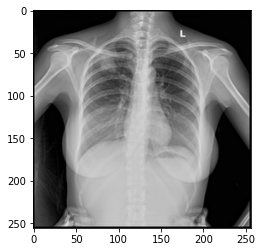

In [13]:
plt.imshow(a)

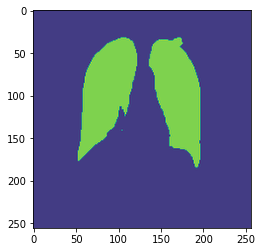

In [14]:
plt.imshow(b)

In [17]:
attributions = xrai_masks(path2img, local_model)

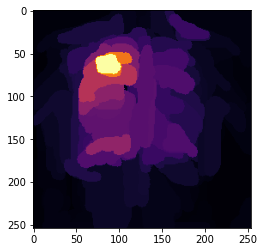

In [19]:
plt.imshow(attributions, cmap = 'inferno')

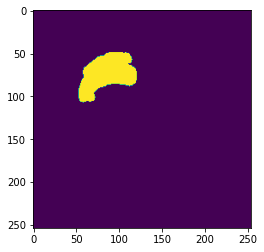

In [20]:
mask = attributions > np.percentile(attributions, 95)
plt.imshow(mask)

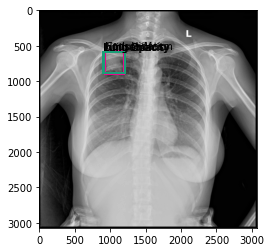

In [34]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom', train_label_bb, '0005e8e3701dfb1dd93d53e2ff537b6e')

### Example 2

In [23]:
path2img = os.path.join(data_dir['train'] + '00ad02393a5d0bd1e0dcf3196433499f' + '.png')

In [24]:
with torch.no_grad():
    local_model.eval()
    out = local_model(torch.unsqueeze(test_tranform(Image.open(path2img)), dim = 0)) 

In [25]:
local_labels[np.argmax(out.numpy() > 0.5)]

'No finding'

In [26]:
a,b = lung_seg(path2img, model = seg_model, back = True)

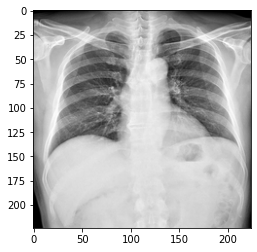

In [27]:
plt.imshow(a)

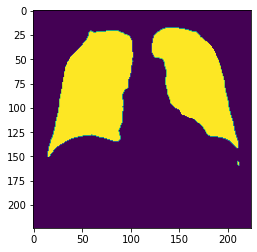

In [28]:
plt.imshow(b)

In [29]:
attributions = xrai_masks(path2img, local_model)

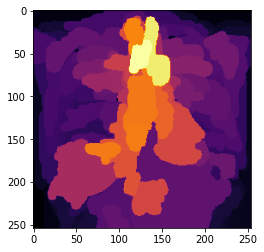

In [30]:
plt.imshow(attributions, cmap = 'inferno')

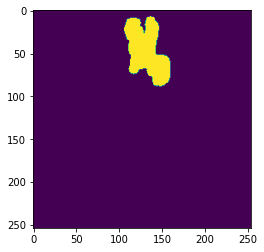

In [31]:
mask = attributions > np.percentile(attributions, 95)
plt.imshow(mask)

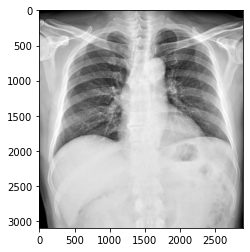

In [35]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/00ad02393a5d0bd1e0dcf3196433499f.dicom', train_label_bb, '00ad02393a5d0bd1e0dcf3196433499f')

#### Test

In [10]:
path2img = os.path.join(data_dir['test'] + 'e0dc2e79105ad93532484e956ef8a71a' + '.png')

In [11]:
with torch.no_grad():
    local_model.eval()
    out = local_model(torch.unsqueeze(test_tranform(Image.open(path2img).resize((224,224), resample = Image.LANCZOS)), dim = 0)) 

In [12]:
local_labels[np.argmax(out.numpy() > 0.5)]

'Pleural effusion'

In [13]:
a,b = lung_seg(path2img, model = seg_model, back = True)

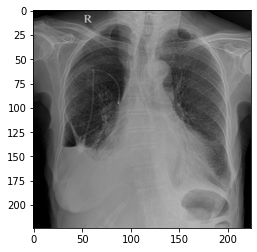

In [15]:
plt.imshow(a)

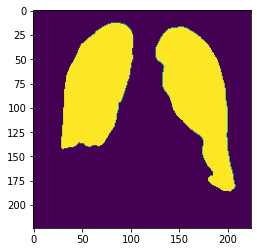

In [14]:
plt.imshow(b)

In [18]:
attributions = xrai_masks(path2img, local_model)

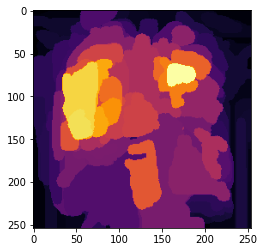

In [25]:
plt.imshow(attributions, cmap = 'inferno')

In [33]:
mask = attributions > np.percentile(attributions, 90)


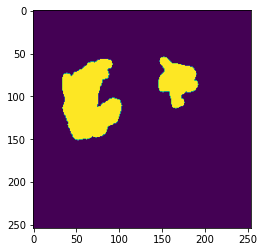

In [34]:
plt.imshow(mask)

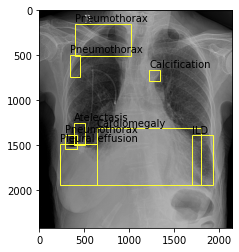

In [69]:
plot_bb('/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/test/e0dc2e79105ad93532484e956ef8a71a.dicom', test_label_bb, 'e0dc2e79105ad93532484e956ef8a71a')

In [ ]:
path2img = os.path.join(data_dir['test'] + 'e0dc2e79105ad93532484e956ef8a71a' + '.png')